# PV3 Visualisations of data gaps

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>

# Imports

In [1]:
import sys
import os
import getpass
import pandas as pd
import numpy as np
import json
from datetime import datetime
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v1 (jupyter)'
project = 'pv3'

# Database Connection

In [2]:
def postgres_session():
    """SQLAlchemy session object with valid connection to sonnja database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = 'localhost' # input('host (default 127.0.0.1): ')
    port = '5432' # input('port (default 5432): ')
    database = 'sonnja_db' # input("database name (default 'sonnja_db'): ")
    user = 'sonnja' # input('user (default sonnja): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# start session
con = postgres_session()

<ipython-input-2-00a32a837366>:11: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# Select measurement data

Requires script: htw_pv3_postgresql_06_data_join.sql

In [3]:
# Select metadata
sql = text("""SELECT obj_description('pv3.htw_weatherdata_2015'::regclass);""")
meta_str = pd.read_sql_query(sql, con).loc[0, 'obj_description']

In [4]:
# Select data - join
sql = text("""
    SELECT  *   -- column
    FROM    pv3.pv3_time_sun_weather_allwr_2015_mview  -- table
    """)
df_tswwr = pd.read_sql_query(sql, con)
df_tswwr = df_tswwr.set_index('timestamp')
df_tswwr.head(3)

,date,time,sunrise,sunset,g_hor_cmp6,g_hor_si,g_gen_cmp11,g_gen_si,ev_beleuchtung,v_wind,...,wr5_eta_wr,wr5_t_wr,wr5_t_pv,wr5_r_iso,wr5_time_total,wr5_time_feedin,wr5_status,wr5_fehler,wr5_istberechnet,wr5_pr
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01,00:00:00,09:18:48,17:01:45,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:01:00,2015-01-01,00:01:00,09:18:48,17:01:45,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:02:00,2015-01-01,00:02:00,09:18:48,17:01:45,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Select data - filled
sql = text("""
    SELECT  *
    FROM    pv3.pv3_time_sun_weather_allwr_2015_fill
    ORDER BY timestamp ASC
    """)
df_tswwr_fill = pd.read_sql_query(sql, con)
df_tswwr_fill.head(3)

,timestamp,date,time,sunrise,sunset,g_hor_cmp6,g_hor_si,g_gen_cmp11,g_gen_si,ev_beleuchtung,...,wr5_istberechnet,wr5_pr,is_gap,is_gap_weather,is_gap_wr,is_during_day,gap_method,is_filled,is_filled_weather,is_filled_wr
0,2015-01-01 00:00:00,2015-01-01,00:00:00,09:18:48,17:01:45,0,0.0,0.0,3,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False
1,2015-01-01 00:01:00,2015-01-01,00:01:00,09:18:48,17:01:45,0,0.0,0.0,3,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False
2,2015-01-01 00:02:00,2015-01-01,00:02:00,09:18:48,17:01:45,0,0.0,0.0,3,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False


# Select related gaps
Requires script: htw_pv3_postgresql_07_data_analysis.sql

In [6]:
# Select all related gaps table
sql = text("""
    SELECT  *
    FROM    pv3.pv3_related_gaps
    WHERE   dataset = 'weather'
    ORDER BY date
    """)
df_only_related_gaps = pd.read_sql_query(sql, con)
df_only_related_gaps

,id,dataset,gap_count,date,ts_start,ts_end,sunrise,sunset,during_day
0,1,weather,5,2015-01-01,2015-01-01 02:02:00,2015-01-01 02:06:00,09:18:48,17:01:45,FALSE
1,2,weather,4,2015-05-10,2015-05-10 02:03:00,2015-05-10 02:06:00,05:22:48,20:44:36,FALSE
2,3,weather,4,2015-11-23,2015-11-23 02:03:00,2015-11-23 02:06:00,08:42:54,17:02:44,FALSE
3,4,weather,3,2015-11-30,2015-11-30 02:04:00,2015-11-30 02:06:00,08:53:57,16:56:15,FALSE
4,5,weather,1,2015-12-01,2015-12-01 02:03:00,2015-12-01 02:03:00,08:55:26,16:55:32,FALSE
5,6,weather,1,2015-12-02,2015-12-02 02:03:00,2015-12-02 02:03:00,08:56:51,16:54:50,FALSE
6,13,weather,1,2015-12-04,2015-12-04 12:51:00,2015-12-04 12:51:00,08:59:37,16:53:40,TRUE
7,14,weather,1,2015-12-04,2015-12-04 13:06:00,2015-12-04 13:06:00,08:59:37,16:53:40,TRUE
8,15,weather,5,2015-12-04,2015-12-04 13:13:00,2015-12-04 13:17:00,08:59:37,16:53:40,TRUE
9,16,weather,1,2015-12-04,2015-12-04 13:42:00,2015-12-04 13:42:00,08:59:37,16:53:40,TRUE


In [7]:
# Select related gaps weather
sql = text("""
    SELECT  *
    FROM    pv3.pv3_data_analysis_weather_days_mview
    """)
df_related_gaps_days_mv = pd.read_sql_query(sql, con)
df_related_gaps_days_mv

,date,sum,during_day
0,2015-01-01,5,FALSE
1,2015-05-10,4,FALSE
2,2015-11-23,4,FALSE
3,2015-11-30,3,FALSE
4,2015-12-01,1,FALSE
5,2015-12-02,1,FALSE
6,2015-12-04,8,FALSE
7,2015-12-04,24,TRUE


# Select filled data

In [8]:
# Select all related gaps table
sql = text("""
    SELECT  *
    FROM    pv3.pv3_time_sun_weather_allwr_2015_fill
    WHERE   is_filled_weather IS TRUE
    """)
df_only_filled = pd.read_sql_query(sql, con)
df_only_filled

,timestamp,date,time,sunrise,sunset,g_hor_cmp6,g_hor_si,g_gen_cmp11,g_gen_si,ev_beleuchtung,...,wr5_istberechnet,wr5_pr,is_gap,is_gap_weather,is_gap_wr,is_during_day,gap_method,is_filled,is_filled_weather,is_filled_wr
0,2015-12-04 11:32:00,2015-12-04,11:32:00,08:59:37,16:53:40,51,42.4,40.2,0,5.3,...,0.0,0.0,True,True,True,True,1,True,True,True
1,2015-12-04 21:55:00,2015-12-04,21:55:00,08:59:37,16:53:40,0,0.0,0.0,0,0.0,...,0.0,0.0,True,True,True,False,0,True,True,True
2,2015-12-02 02:03:00,2015-12-02,02:03:00,08:56:51,16:54:50,0,0.0,0.0,0,0.0,...,1.0,0.0,True,True,False,False,0,True,True,False
3,2015-01-01 02:03:00,2015-01-01,02:03:00,09:18:48,17:01:45,0,0.0,0.0,0,0.0,...,1.0,0.0,True,True,False,False,0,True,True,False
4,2015-11-30 02:04:00,2015-11-30,02:04:00,08:53:57,16:56:15,0,0.0,0.0,0,0.0,...,1.0,0.0,True,True,False,False,0,True,True,False
5,2015-12-04 18:53:00,2015-12-04,18:53:00,08:59:37,16:53:40,0,0.0,0.0,0,0.0,...,0.0,0.0,True,True,True,False,0,True,True,True
6,2015-12-04 23:07:00,2015-12-04,23:07:00,08:59:37,16:53:40,0,0.0,0.0,0,0.0,...,0.0,0.0,True,True,True,False,0,True,True,True
7,2015-01-01 02:04:00,2015-01-01,02:04:00,09:18:48,17:01:45,0,0.0,0.0,0,0.0,...,1.0,0.0,True,True,False,False,0,True,True,False
8,2015-05-10 02:04:00,2015-05-10,02:04:00,05:22:48,20:44:36,0,0.0,0.0,0,0.0,...,1.0,0.0,True,True,False,False,0,True,True,False
9,2015-01-01 02:06:00,2015-01-01,02:06:00,09:18:48,17:01:45,0,0.0,0.0,0,0.0,...,1.0,0.0,True,True,False,False,0,True,True,False


# Metadata

The important information from the above select (**df**) is collected in a Dictionary (**info_dict**).

In [9]:
# Facts dict
info_dict = {}
info_dict['Day'] = ['2015-12-04']
info_dict['Filename'] = ['{}_pv3_sonnja_plot_day_with_gap'.format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict['Value'] = ['Horizontale Globalstrahlung (g_hor_si)']
info_dict['Unit'] = ['W/m^2']
info_dict['Y-Axis'] = ['{} in {}'.format(*info_dict['Value'], *info_dict['Unit'])]
info_dict['X-Axis'] = ['Minute im Jahr']
info_dict['Title'] = ['Tag mit Messlücke ({})'.format(*info_dict['Day'])]
info_dict['Metadata'] = [meta_str]

# Print facts
for x in info_dict:
    print(x,':',info_dict[x])

Day : ['2015-12-04']
Filename : ['2021-05-19_pv3_sonnja_plot_day_with_gap']
Value : ['Horizontale Globalstrahlung (g_hor_si)']
Unit : ['W/m^2']
Y-Axis : ['Horizontale Globalstrahlung (g_hor_si) in W/m^2']
X-Axis : ['Minute im Jahr']
Title : ['Tag mit Messlücke (2015-12-04)']
Metadata : ['{\n    "name": "pv3.htw_weatherdata_2015",\n    "title": "HTW Weatherdata",\n    "id": null,\n    "description": "HTW Weatherdata 2015",\n    "language": [\n        "en-GB",\n\t\t"de-DE"\n    ],\n    "keywords": [\n        "weatherdata"\n    ],\n    "publicationDate": null,\n    "context": {\n        "homepage": "https://re-master.htw-berlin.de/",\n        "documentation": "Solaranlangen und -kraftwerke (W-PV3)",\n        "sourceCode": "https://github.com/htw-pv3/weather-data",\n        "contact": "ludwig.huelk@rl-institut.de",\n        "grantNo": null,\n        "fundingAgency": null,\n        "fundingAgencyLogo": null,\n        "publisherLogo": "https://corporatedesign.htw-berlin.de/files/Presse/_tmp_

# Visualise selected day

In [10]:
# Filter day
day = datetime.fromisoformat('{}'.format(*info_dict['Day'])).date()
df_day = df_tswwr_fill[(df_tswwr_fill['date'] == day)]
df_day.head()

,timestamp,date,time,sunrise,sunset,g_hor_cmp6,g_hor_si,g_gen_cmp11,g_gen_si,ev_beleuchtung,...,wr5_istberechnet,wr5_pr,is_gap,is_gap_weather,is_gap_wr,is_during_day,gap_method,is_filled,is_filled_weather,is_filled_wr
485280,2015-12-04 00:00:00,2015-12-04,00:00:00,08:59:37,16:53:40,3,0.0,0.0,2,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False
485281,2015-12-04 00:01:00,2015-12-04,00:01:00,08:59:37,16:53:40,4,0.0,0.0,2,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False
485282,2015-12-04 00:02:00,2015-12-04,00:02:00,08:59:37,16:53:40,5,0.0,0.0,2,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False
485283,2015-12-04 00:03:00,2015-12-04,00:03:00,08:59:37,16:53:40,4,0.0,0.0,3,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False
485284,2015-12-04 00:04:00,2015-12-04,00:04:00,08:59:37,16:53:40,3,0.0,0.0,3,0.0,...,0.0,0.0,False,False,False,False,NaN,False,False,False


(0.0, 132.3)

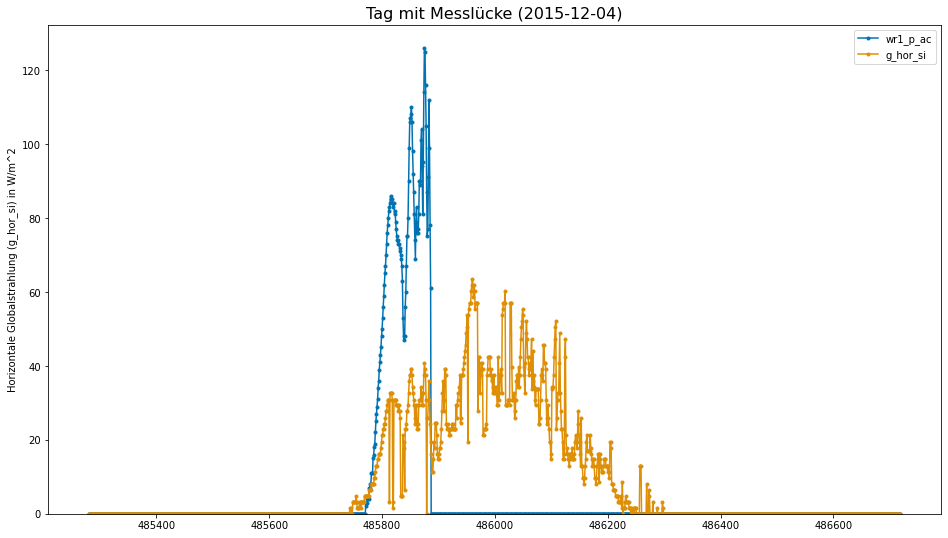

In [11]:
df_plot = df_day[['wr1_p_ac','g_hor_si']]

sns.set_palette("colorblind")
mfig = plt.figure(figsize=(16, 9))
ax = plt.subplot()
plt.title(*info_dict['Title'], fontsize=16)         # Title from info
plt.ylabel(*info_dict['Y-Axis'])                    # Label from info
df_plot.plot(ax=ax, marker='o', markersize=3, linestyle='-')
ax.set_ylim(ymin=0)

## Interactive Plot with Metadata

In [12]:
# Interactive plot
data = [
    go.Scatter(x=df_day.index.tolist(), 
               y=df_day['g_hor_si'].tolist(), 
               name='g_hor_si', mode='markers'),
]
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

In [13]:
import plotly.express as px
fig = px.scatter(df_day, x="timestamp", y="g_hor_si", color="is_filled_weather", title=''.join(info_dict['Title']),)

fig.show()

In [14]:
# Interactive plot - filled
# not finished
data = [
    go.Scatter(x=df_day.index.tolist(), 
               y=df_day['wr1_p_ac'].tolist(), 
               name='WR1', mode='markers'),
    go.Scatter(x=df_day.index.tolist(), 
               y=df_day['wr2_p_ac'].tolist(), 
               name='WR2', mode='markers'),
    go.Scatter(x=df_day.index.tolist(), 
               y=df_day['wr3_p_ac'].tolist(), 
               name='WR3', mode='markers'),
    go.Scatter(x=df_day.index.tolist(), 
               y=df_day['wr4_p_ac'].tolist(), 
               name='WR4', mode='markers'),
    go.Scatter(x=df_day.index.tolist(), 
               y=df_day['wr5_p_ac'].tolist(), 
               name='WR5', mode='markers'),
    go.Scatter(x=df_day.index.tolist(), 
               y=df_day['g_hor_si'].tolist(), 
               name='g_hor_si', mode='markers')#,
    #go.Scatter(x=df_only_filled.index.tolist(), 
    #           y=df_day['g_hor_si'].tolist(), 
    #           name='df_filled', mode='markers')
]
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

### One WR

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.

In [15]:
# Write facts to textfile
txtname = ('data/{}.txt').format(*info_dict['Filename'])
with open(txtname,'w') as tfile:
    for i in info_dict.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict[i]]) + "\n")
tfile.close()
print("Facts saved to file:", txtname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict['Filename'])
mfig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

Facts saved to file: data/2021-05-19_pv3_sonnja_plot_day_with_gap.txt
Plot saved to file: data/2021-05-19_pv3_sonnja_plot_day_with_gap.png
Interactive plot saved to file: data/2021-05-19_pv3_sonnja_plot_day_with_gap.html
